## Data Curation Part 2

Once a category was explored I will continue to extend the dataset to contain the remaining categories and to complete the really big dataset that can be used for training and RAG

## Imports

In [3]:
# Watching for changes in modules
%load_ext autoreload
%autoreload 2

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

import sys
sys.path.append(os.path.abspath('..'))
from utils.items import Item
from utils.loaders import ItemLoader

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
# os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
os.environ['HF_USER'] = os.getenv('HF_USER', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Loading data faster

Since now we load a huge dataset I will use concurrency in Python to speed up the process. You can find this code in the "utils.loaders.py" file.

In [5]:
# Load in the same dataset as before using ItemLoader

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [00:49<00:00,  1.91it/s]


Completed Appliances with 28,653 datapoints in 0.9 mins


In [8]:
len(items)

28653

In [9]:
print(items[100].prompt)

How much does this cost to the nearest dollar?

2-Pack Replacement for Samsung Refrigerator Water Filter - Compatible with Samsung HAF-CIN Fridge Water Filter Cartridge
This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by Denali Pure. Replacement for Filter Manufacturer Denali Pure, Part model number Is Discontinued No, Rank Tools & Home Improvement In-Refrigerator Water Filters 3632, Available May 27, 2015, Duration 6 \tmonths, External Testing Certification ANSI, NSF, Brand

Price is $22.00


## Adding the other categories

Next we will complete the dataset by including the categories named in the next list

In [10]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [11]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


100%|██████████| 2004/2004 [21:54<00:00,  1.52it/s]


Completed Automotive with 934,378 datapoints in 22.3 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [14:35<00:00,  1.84it/s]


Completed Electronics with 450,179 datapoints in 14.9 mins
Loading dataset Office_Products


100%|██████████| 711/711 [04:27<00:00,  2.66it/s]


Completed Office_Products with 243,956 datapoints in 4.6 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████| 1474/1474 [13:12<00:00,  1.86it/s]


Completed Tools_and_Home_Improvement with 546,920 datapoints in 13.5 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████| 1289/1289 [08:16<00:00,  2.60it/s]


Completed Cell_Phones_and_Accessories with 239,530 datapoints in 8.5 mins
Loading dataset Toys_and_Games


100%|██████████| 891/891 [06:39<00:00,  2.23it/s]


Completed Toys_and_Games with 343,948 datapoints in 6.8 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:50<00:00,  1.87it/s]


Completed Appliances with 28,653 datapoints in 0.9 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [01:22<00:00,  2.58it/s]


Completed Musical_Instruments with 68,154 datapoints in 1.5 mins


In [12]:
print(f"There is a total of {len(items):,} items")

There is a total of 2,855,718 items


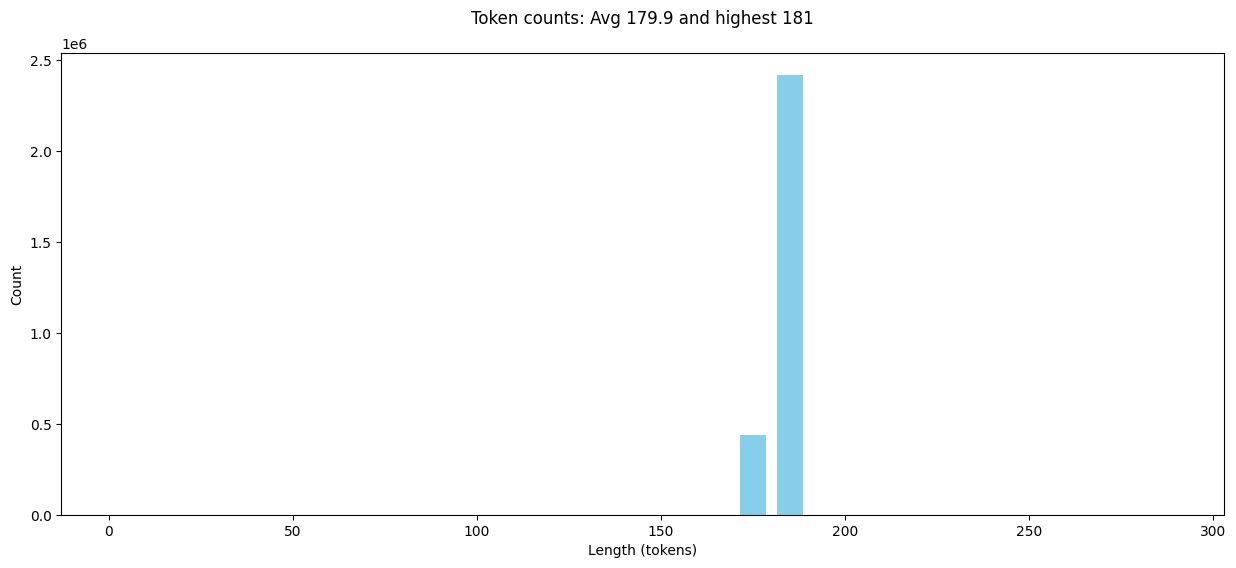

In [13]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

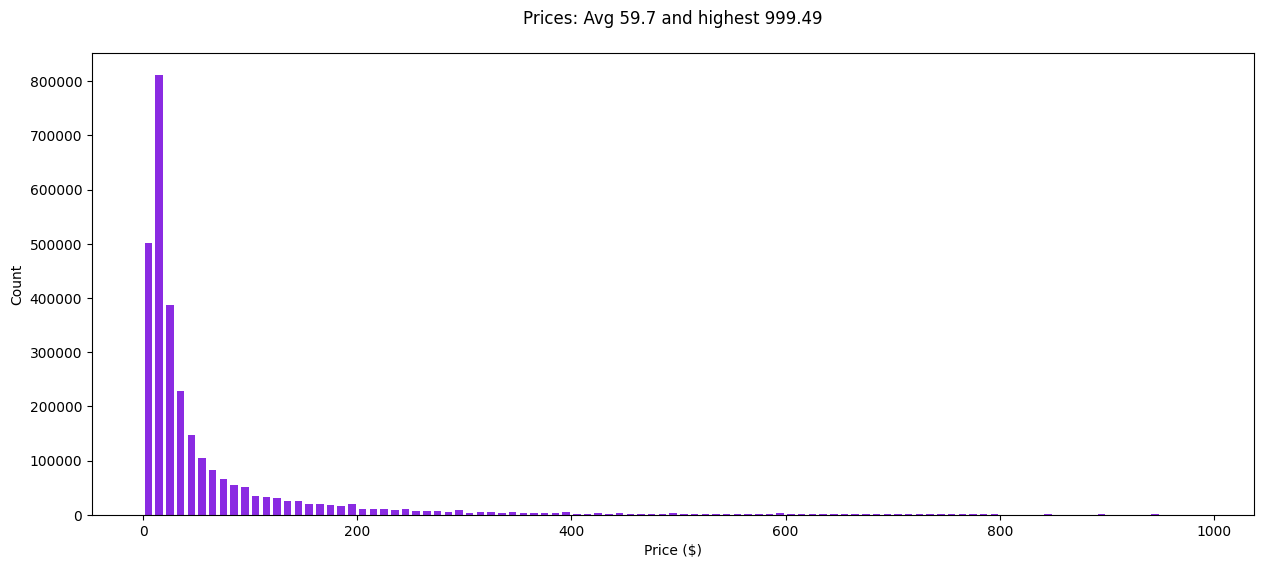

In [14]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

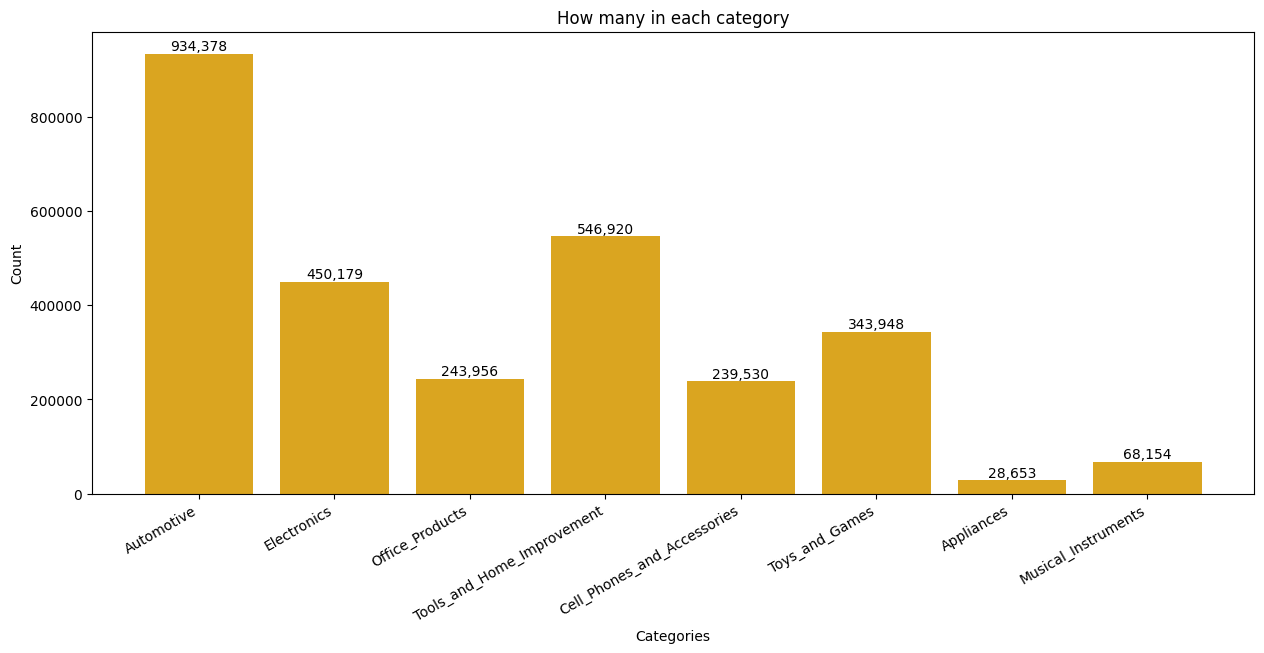

In [15]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

## Observation

The dataset needs to be more balanced in terms of prices. Less heavily scewed to cheap items. Additionally, there's an unbalance in the number of Automotive items.

In [16]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [21]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 411,821 items in the sample


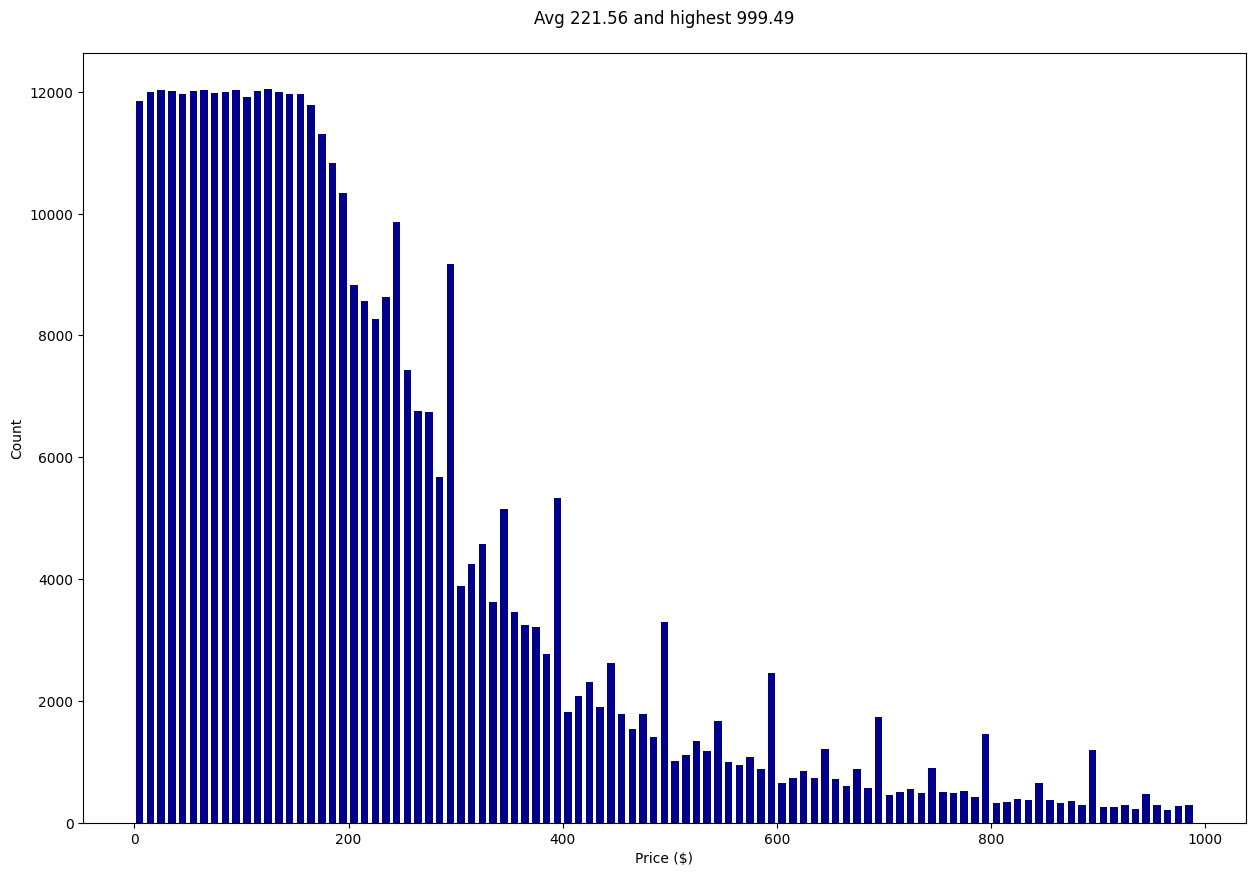

In [22]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

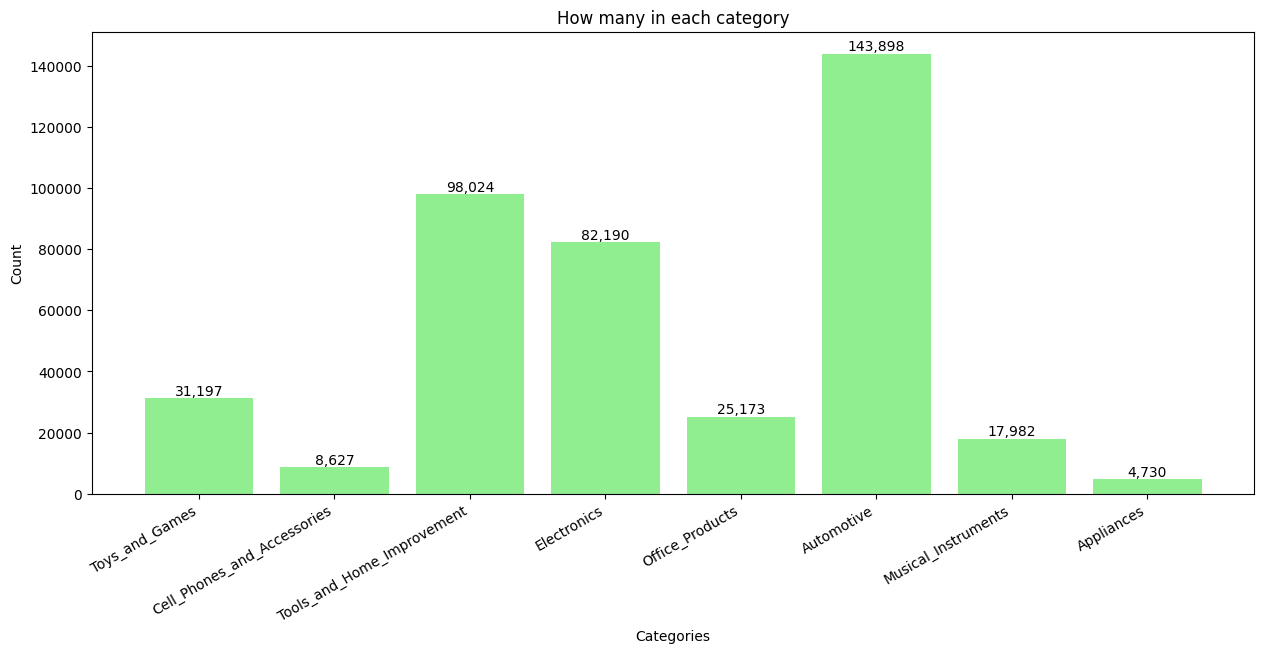

In [23]:
# Categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

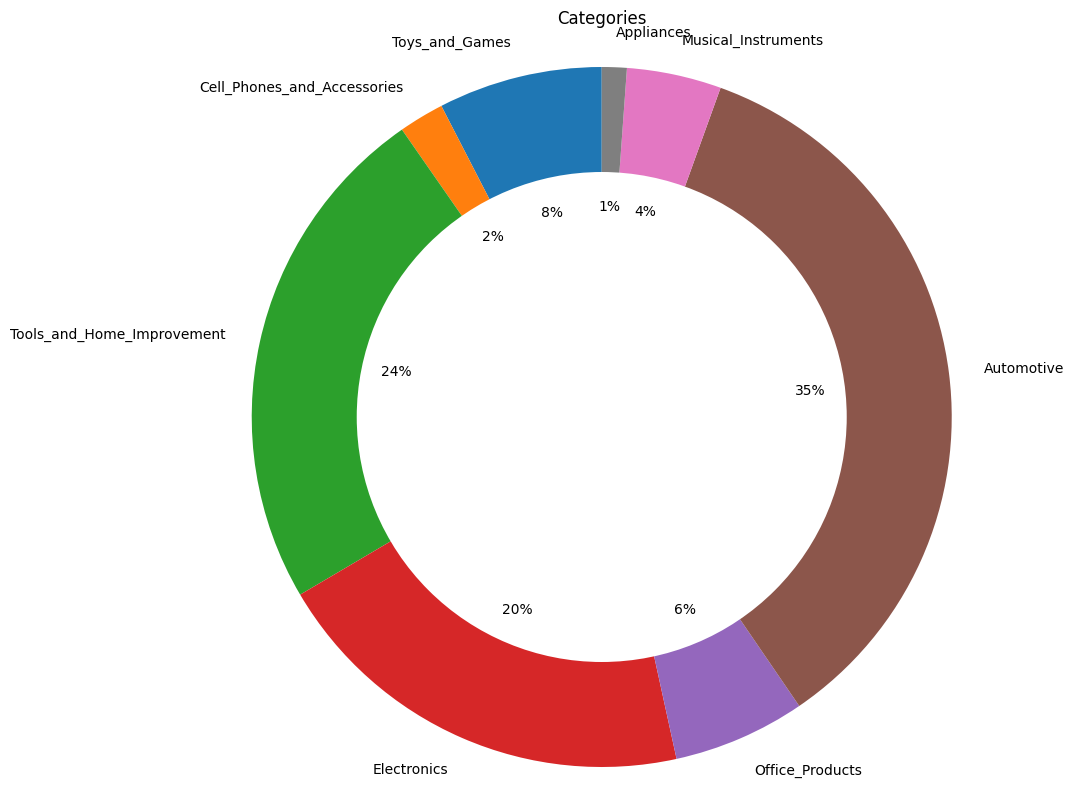

In [24]:
plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

## Final Check

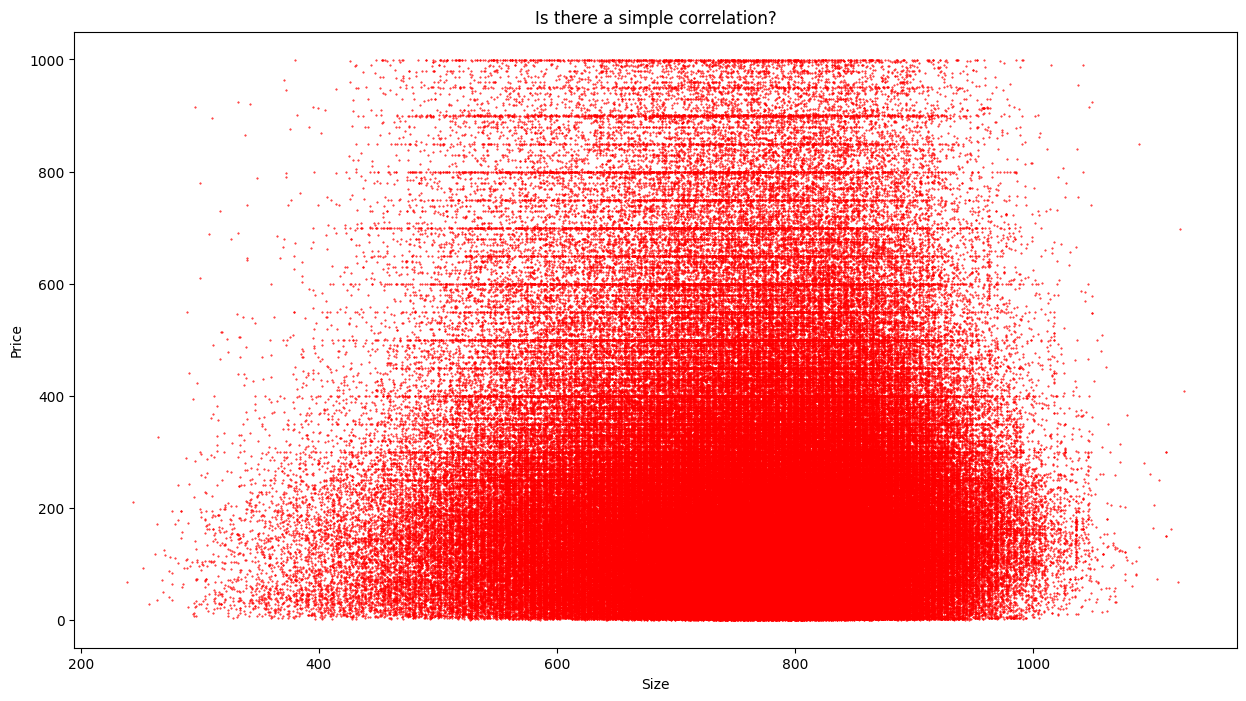

In [25]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

## Creating the Training, Test and Validation Datasets

In [29]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
validation = sample[400_000:404_000]
test = sample[404_000:408_000]
print(f"Divided into a training set of {len(train):,} items, validation set of {len(validation):,} items and test set of {len(test):,} items.")

Divided into a training set of 400,000 items, validation set of 4,000 items and test set of 4,000 items.


In [30]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

WeatherTech Custom Fit FloorLiners for Hyundai Palisade - 1st & 2nd Row Grey
Fits select Hyundai Palisade Models. Please confirm fitment to your year, make, and model in Amazon ConfirmedFit prior to purchase. Coverage Area 1st & 2nd Row, Color Grey The FloorLiner is proudly designed, engineered, and manufactured with American made tooling in the USA. A patented High-Density Tri-Extruded (HDTE) material allows for a rigid core for strength while offering surface friction to the carpet, as well as a tactile feel to the surface! Advanced surfacing creates channels that carry fluids and debris to a lower reservoir with further channeling to help minimize fluid movement while driving! Images may be representative and may not reflect the actual vehicle or part. Manufacturer

Price is $218.00


In [32]:
print(validation[0].test_prompt())

How much does this cost to the nearest dollar?

Arlo Q 1080p Hd Security Camera With Audio 2 Pack
See and hear in perfect detail with the Arlo Q HD security camera. Experience a new sense of security with 1080p HD video, night vision and 2-way audio. Arlo Q comes with FREE 7 days history of cloud recordings and flexible options to upgrade to non-stop continuous cloud recording. Works with Alexa for voice control (Alexa device sold separately). Stream live video 24/7 and watch past recordings in sharp 1080p HD resolution from anywhere in the world using your smartphone, tablet, or computer Save on expensive subscription fees with FREE cloud storage that lets you view, share, and download recordings from the past 7 days at no cost.

Price is $


In [31]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Sony M530V Microcassette Recorder
Amazon.com This handheld mini-cassette recorder is great for office dictation or lecture recording. Sony ClearVoice technology dramatically improves voice quality for both record and playback. From the Manufacturer This handheld mini-cassette recorder is great for office dictation or lecture recording. Sony ClearVoice technology dramatically improves voice quality for both record and playback. Built-in microphone and speaker Capable of continuous or voice-activated recording 2 speeds for record and play Works for up to 24 hours on 2 AA batteries Automatic, recording with auto record level Dimensions 3.75 x 2.5 x 1.5 inches, Weight 2.4 ounces, model number M530V, Batteries 2 AA batteries required., Rank

Price is $


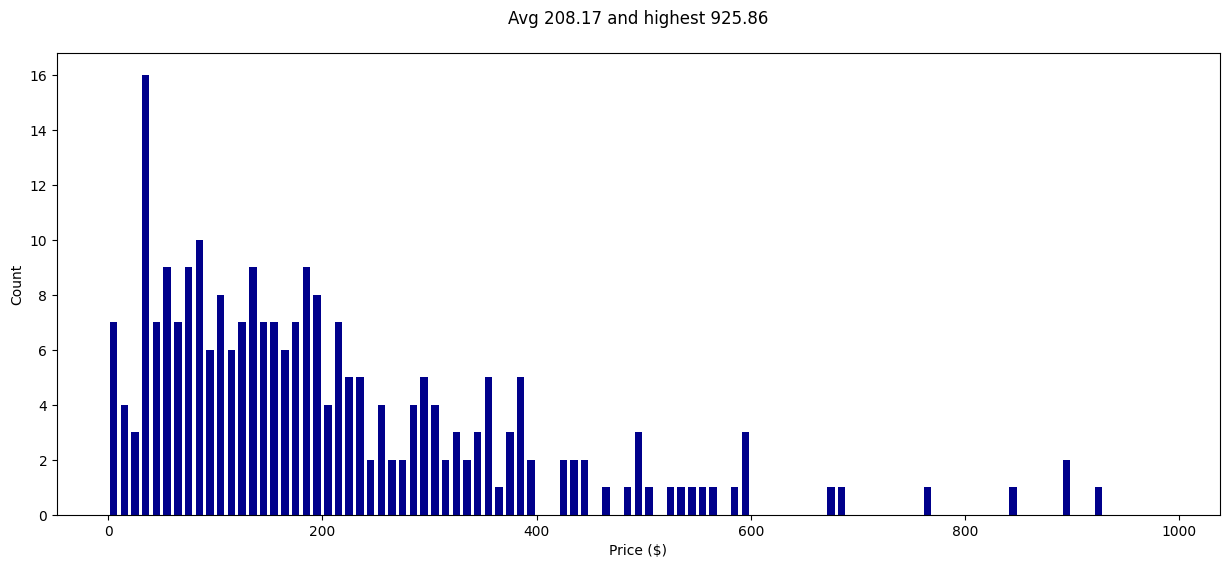

In [33]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

## Uploading data to HuggingFace hub.

In [34]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
validation_prompts = [item.test_prompt() for item in validation]
validation_prices = [item.price for item in validation]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [35]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
validation_dataset = Dataset.from_dict({"text": validation_prompts, "price": validation_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})

In [ ]:
DATASET_NAME = f"{HF_USER}/Amazon-reviews-pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/ValentinHuggingFace/Amazon-reviews-pricer-data/commit/7de65fde56209ee38f7719286e9ed2856724689d', commit_message='Upload dataset', commit_description='', oid='7de65fde56209ee38f7719286e9ed2856724689d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ValentinHuggingFace/Amazon-reviews-pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ValentinHuggingFace/Amazon-reviews-pricer-data'), pr_revision=None, pr_num=None)

In [40]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('../Data/train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('../Data/validation.pkl', 'wb') as file:
    pickle.dump(validation, file)

with open('../Data/test.pkl', 'wb') as file:
    pickle.dump(test, file)